In [1]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import sequence, text
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import Series,DataFrame
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import scipy as sp

%matplotlib inline
stop_words = stopwords.words('english')

/home/katsuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train['Family'] = train.Parch + train.SibSp
# 数字を、文字列に変換します。
train['Alone'] = train['Family'].apply(lambda x : 'With Family' if x > 0 else 'Alone')

In [161]:
def split_word(x):
    x_list = x.split() 
    for i,w in enumerate(x_list):
        if w.find('.')> -1:
            return x_list[i:i+2]

In [162]:
name_df = pd.DataFrame(list(train.Name.map(split_word).values),columns=['M','FamilyName'])

In [147]:
df = pd.DataFrame()
df['Fare'] = train['Fare'].fillna(train['Fare'].median())
df['Age'] = train['Age'].fillna(train['Age'].median())
#train['Embarked'] = train['Embarked'].fillna('U')
#lbl = LabelEncoder()
#df['Embarked'] = lbl.fit_transform(train['Embarked'].values)
df['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Family'] = train['Family'].fillna(train['Family'].median())
lbl = LabelEncoder()
df['M'] = lbl.fit_transform(name_df['M'].values)
#lbl = LabelEncoder()
#df['FamilyName'] = lbl.fit_transform(name_df['FamilyName'].values)

In [148]:
lbl = preprocessing.LabelEncoder()
df['Survived'] = lbl.fit_transform(train.Survived)

In [149]:
X = df.drop('Survived', axis=1)
y = df.Survived

In [154]:
(train_X, test_X ,train_y, test_y) = train_test_split(X, y, test_size = 0.3, random_state = 666)

In [155]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)

In [156]:
clf = RandomForestClassifier(n_estimators=60, n_jobs=-1,random_state=0)
clf = clf.fit(train_X, train_y)
pred = clf.predict(test_X)

In [157]:
fpr, tpr, thresholds = roc_curve(test_y, pred, pos_label=1)
print(auc(fpr, tpr))
print(accuracy_score(pred, test_y))

0.8258323235820206
0.8395522388059702


In [158]:
#可視化
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
from sklearn import tree
import pydotplus as pdp

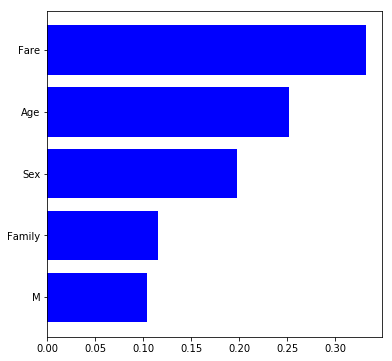

In [159]:
import matplotlib.pyplot as plt
%matplotlib inline

features = train_X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

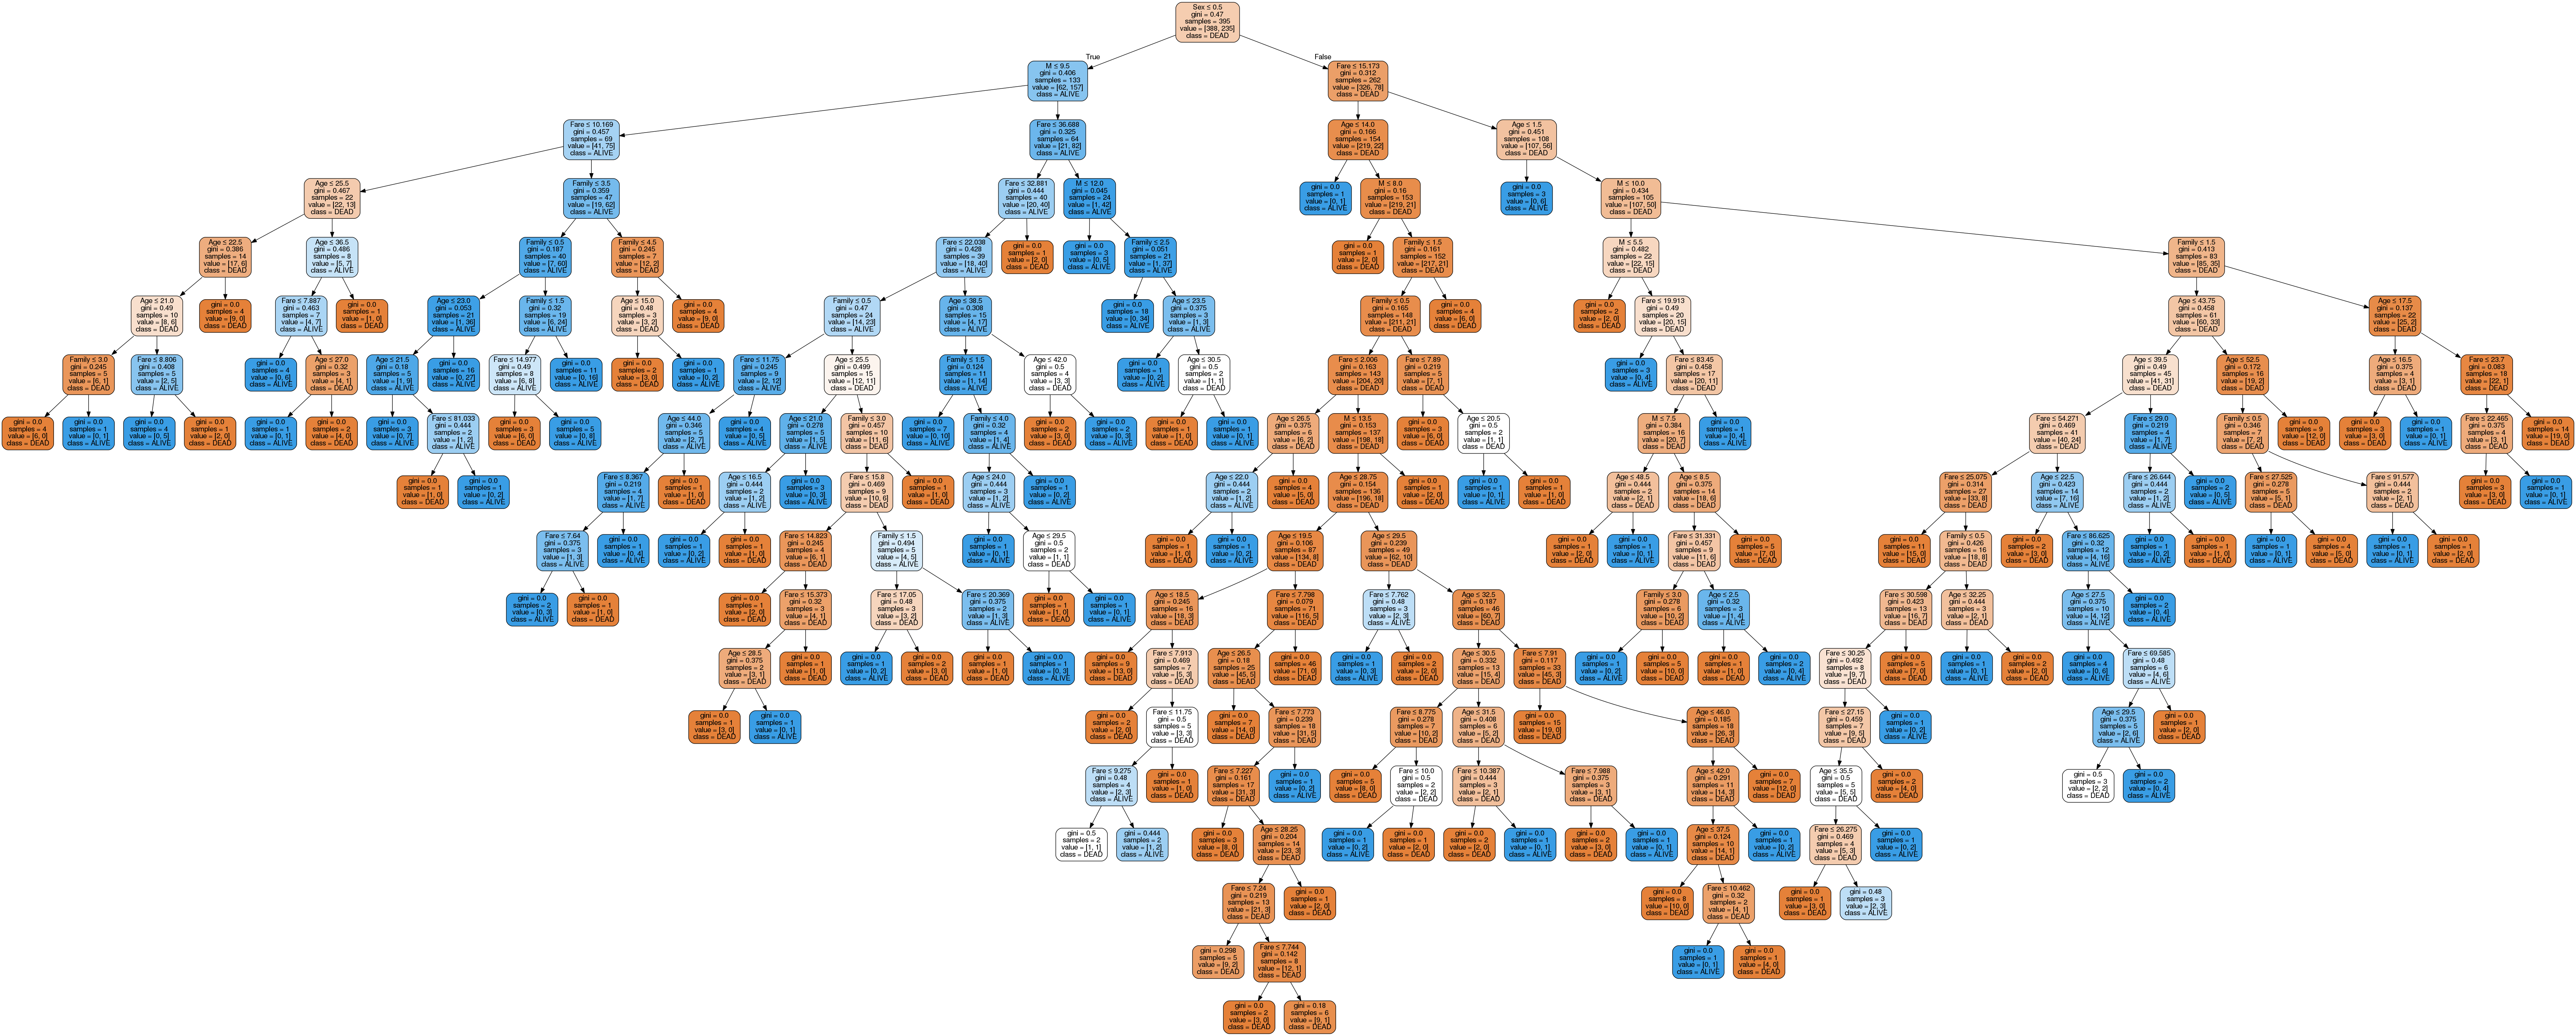

In [160]:
estimators = clf.estimators_
file_name = "./tree_visualization.png"
dot_data = tree.export_graphviz(estimators[0], # 決定木オブジェクトを一つ指定する
                                out_file=None, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
                                filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
                                rounded=True, # Trueにすると、ノードの角を丸く描画する。
                                feature_names=X.columns, # これを指定しないとチャート上で特徴量の名前が表示されない
                                class_names=['DEAD','ALIVE'], # これを指定しないとチャート上で分類名が表示されない
                                special_characters=True # 特殊文字を扱えるようにする
                                )
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png(file_name)
Image(graph.create_png())

# Test_main

In [164]:
test['Family'] = test.Parch + test.SibSp
# 数字を、文字列に変換します。
test['Alone'] = test['Family'].apply(lambda x : 'With Family' if x > 0 else 'Aone')
name_df = pd.DataFrame(list(test.Name.map(split_word).values),columns=['M','FamilyName'])

In [165]:
df = pd.DataFrame()
df['Fare'] = test['Fare'].fillna(test['Fare'].median())
df['Age'] = test['Age'].fillna(test['Age'].median())
#test['Embarked'] = test['Embarked'].fillna('U')
#lbl = LabelEncoder()
#df['Embarked'] = lbl.fit_transform(test['Embarked'].values)
df['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Family'] = test['Family'].fillna(test['Family'].median())
lbl = LabelEncoder()
df['M'] = lbl.fit_transform(name_df['M'].values)
#lbl = LabelEncoder()
#df['FamilyName'] = lbl.fit_transform(name_df['FamilyName'].values)

In [17]:
test["Survived"] = rfc_model.predict(sp.sparse.hstack([sex,age,pclass,fare,family]))

In [167]:
clf = RandomForestClassifier(n_estimators=60, n_jobs=-1,random_state=0)
clf = clf.fit(X, y)
test["Survived"] = clf.predict(df)

In [176]:
df

,Fare,Age,Sex,Family,M
0,7.8292,34.5,1,0,5
1,7.0000,47.0,0,1,6
2,9.6875,62.0,1,0,5
3,8.6625,27.0,1,0,5
4,12.2875,22.0,0,2,6
5,9.2250,14.0,1,0,5
6,7.6292,30.0,0,0,4
7,29.0000,26.0,1,2,5
8,7.2292,18.0,0,0,6
9,24.1500,21.0,1,2,5


In [169]:
test[["PassengerId","Survived"]].to_csv('predict_test.csv',index=False)

In [170]:
!kaggle competitions submit -c titanic -f  predict_test.csv -m "rfc_Fare_Age_Sex_Family_M"

Successfully submitted to Titanic: Machine Learning from Disaster

In [171]:
!kaggle competitions submissions -c titanic

fileName          date                 description                     status    publicScore  privateScore  
----------------  -------------------  ------------------------------  --------  -----------  ------------  
predict_test.csv  2018-09-29 19:55:05  rfc_Fare_Age_Sex_Family_M       complete  0.75598      None          
predict_test.csv  2018-09-29 08:37:32  rfc_sex_age_pclass_fare_family  complete  0.74162      None          
predict_test.csv  2018-09-29 07:30:32  rfc_sex_age_pclass              complete  0.71770      None          
